In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
print("available gpu devices: {}".format(torch.cuda.device_count()))


available gpu devices: 1


In [3]:

torch.manual_seed(1234)

num_neu = 16

iterations = 5000

RHO = 1000      # 1000 kg/m3
CS_2 = 1              # 1m/s
ETA = 1.5       # 1.5 pa·s
A_U0 = 0.001    # 0.001 m/s
SIGMA_U0 = 0.001     # 0.001 m


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2,num_neu)
        self.hidden_layer2 = nn.Linear(num_neu,num_neu)
        self.hidden_layer3 = nn.Linear(num_neu,num_neu)
        self.hidden_layer4 = nn.Linear(num_neu,num_neu)
        # self.hidden_layer5 = nn.Linear(num_neu,num_neu)
        self.output_layer = nn.Linear(num_neu,1)

    def forward(self, x,t):
        inputs = torch.cat([x,t],dim=1) # combined two arrays of 1 columns each to one array of 2 columns
        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
        # layer5_out = torch.tanh(self.hidden_layer3(layer4_out))
        output = self.output_layer(layer4_out) ## For regression, no activation is used in output layer
        return output

In [4]:
### (2) Model
net = Net()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters())

In [5]:
## PDE as loss function. Thus would use the network which we call as u

def gaussian(x):
    return A_U0*torch.exp(-0.5*(x/SIGMA_U0)**2)

def window(t):
    return torch.tensor(((t >= 0) & (t <= 0.000333)).float(), device=device)

def force(x,t):
    return gaussian(x)*window(t)



def f(x,t, net):

    u = net(x,t) # the dependent variable u is given by the network based on independent variables x,t
    

    # First-order derivatives

    u_x = torch.autograd.grad(u, x, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]

    # Second-order derivatives

    u_xx = torch.autograd.grad(u_x, x, grad_outputs = torch.ones_like(u_x), retain_graph = True, create_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t, grad_outputs = torch.ones_like(u_t), retain_graph = True, create_graph=True)[0]

    # pde = 1000*u_tt - 1000*u_xx
    pde =RHO * u_tt - (RHO * CS_2+ (ETA* u_t))* u_xx - force(x,t)
    # pde =RHO * u_tt - (RHO* CS_2+ (ETA* u_t))* u_xx 
    # pde =RHO * u_tt - (RHO)* CS_2* u_xx - force(x,t)
    # pde =RHO * u_tt - RHO* u_xx 
    return pde

In [6]:

num_train_ic_samples = 500
num_train_pde_samples = 10000



# Sampling points for IC
x_bc1 = np.random.uniform(low=0.0, high=0.02, size=(num_train_ic_samples,1))
x_bc2 = np.random.uniform(low=0.0, high=0.02, size=(num_train_ic_samples,1))
# x_bc = np.random.exponential(scale=std_dev_x, size=(num_train_bc_samples,1))
# x_bc = np.clip(x_bc, 0, 20)
t_bc = np.zeros((num_train_ic_samples,1))
u_bc = np.zeros((num_train_ic_samples,1))



# Sampling points for pde

x_collocation = np.random.uniform(low=0, high=0.02, size=(num_train_pde_samples,1))
# x_collocation = np.random.normal(loc=mean_x, scale=std_dev_x, size=(num_train_bc_samples, 1))
# x_collocation = np.random.randint(low=0.0, high=20, size=(num_train_samples,1))
# x_collocation = np.random.exponential(scale=std_dev_x, size=(10000,1))
# x_collocation = np.clip(x_collocation, 0, 0.02)

# x_collocation = x_bc
t_collocation = np.random.uniform(low=0, high=0.02, size=(num_train_pde_samples,1))

all_zeros = np.zeros((num_train_pde_samples,1))

C:\Users\Wayne\AppData\Local\Temp\ipykernel_13528\1158134575.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(t_collocation, x_collocation, c='k', marker='.', alpha=0.2,label='Collocation points',cmap=cm.jet)
C:\Users\Wayne\AppData\Local\Temp\ipykernel_13528\1158134575.py:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))


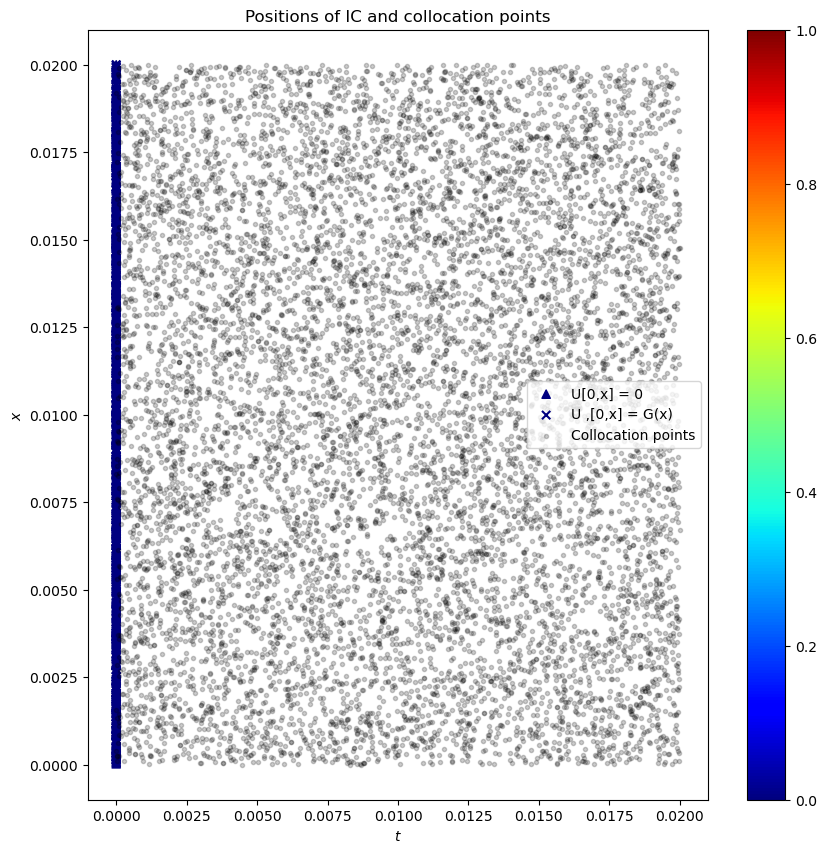

In [7]:


x_bc1 = np.random.uniform(low=0.0, high=0.02, size=(num_train_ic_samples,1))
x_bc2 = np.random.uniform(low=0.0, high=0.02, size=(num_train_ic_samples,1))
t_bc = np.zeros((num_train_ic_samples,1))
u_bc = np.zeros((num_train_ic_samples,1))
dudt_bc =A_U0*np.exp(-0.5*(x_bc2/SIGMA_U0)**2)


x_collocation = np.random.uniform(low=0, high=0.02, size=(num_train_pde_samples,1))
# x_collocation = np.random.exponential(scale=std_dev_x, size=(num_train_samples,1))
# x_collocation = np.clip(x_collocation, 0, 0.002)
t_collocation = np.random.uniform(low=0, high=0.02, size=(num_train_pde_samples,1))
fig = plt.figure(figsize=(10,10))

plt.scatter(t_bc, x_bc1, c=u_bc, marker='^', vmin=0, vmax=20,label='U[0,x] = 0',cmap=cm.jet)
plt.scatter(t_bc, x_bc2, c=dudt_bc, marker='x', vmin=0, vmax=1,label='U ,[0,x] = G(x)',cmap=cm.jet)


cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=1)


plt.scatter(t_collocation, x_collocation, c='k', marker='.', alpha=0.2,label='Collocation points',cmap=cm.jet)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of IC and collocation points');
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))
plt.legend(loc='center right')

In [8]:
### (3) Training / Fitting

previous_validation_loss = 99999999.0

mse_u_values = []
mse_dudt_values = []
mse_f_values = []
total_loss_values = []
loss_distribution_per_epoch = []



for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero
    

    # x_bc1 = np.random.uniform(low=0.0, high=0.02, size=(500,1))
    # x_bc2 = np.random.uniform(low=0.0, high=0.02, size=(500,1))
    # # x_bc = np.random.exponential(scale=std_dev_x, size=(num_train_bc_samples,1))
    # # x_bc = np.clip(x_bc, 0, 20)
    # t_bc = np.zeros((500,1))
    # u_bc = np.zeros((500,1))

    # compute dudt based on IC
    dudt_bc =A_U0*np.exp(-0.5*(x_bc2/SIGMA_U0)**2)
    
    # Loss based on boundary conditions
    pt_x_bc1 = Variable(torch.from_numpy(x_bc1).float(), requires_grad=True).to(device)
    pt_x_bc2 = Variable(torch.from_numpy(x_bc2).float(), requires_grad=True).to(device)
    pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=True).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=True).to(device)
    pt_dudt_bc = Variable(torch.from_numpy(dudt_bc).float(), requires_grad=False).to(device)
    
    net_bc_out1 = net(pt_x_bc1, pt_t_bc)  # output of u(x,t)
    net_bc_out2 =  net(pt_x_bc2, pt_t_bc) # output for dudt-u(x,t)
    mse_u = mse_cost_function(net_bc_out1, pt_u_bc)   #Loss for IC u(t=0)=0

    net_bc_out_du_dt = torch.autograd.grad(net_bc_out2, pt_t_bc, grad_outputs = torch.ones_like(net_bc_out2), retain_graph = True, create_graph=True)[0]  #Output for du_dt
    mse_dudt = mse_cost_function(net_bc_out_du_dt, pt_dudt_bc)      ##Loss for IC dudt(t=0)=G(x)
    
    
    # x_collocation = np.random.uniform(low=0, high=0.02, size=(10000,1))
    # # x_collocation = np.random.normal(loc=mean_x, scale=std_dev_x, size=(num_train_bc_samples, 1))
    # # x_collocation = np.random.randint(low=0.0, high=20, size=(num_train_samples,1))
    # # x_collocation = np.random.exponential(scale=std_dev_x, size=(10000,1))
    # # x_collocation = np.clip(x_collocation, 0, 0.02)

    # # x_collocation = x_bc
    # t_collocation = np.random.uniform(low=0, high=0.02, size=(10000,1))

    # all_zeros = np.zeros((10000,1))
    
   
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    

    
    f_out = f(pt_x_collocation, pt_t_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    
    # Combining the loss functions
    loss = mse_u + mse_dudt + mse_f

    mse_u_values.append(mse_u.item())
    mse_dudt_values.append(mse_dudt.item())
    mse_f_values.append(mse_f.item())
    total_loss_values.append([loss.item()])
    loss_distribution_per_epoch.append(loss.detach().cpu().numpy())
    
    
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta

    with torch.autograd.no_grad():
        print(epoch, "mse_u:", mse_u.item(), "mse_dudt:", mse_dudt.item(), "mse_f:", mse_f.item(), "Total Loss:", loss.item())
        
    

C:\Users\Wayne\AppData\Local\Temp\ipykernel_13528\2835895465.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(((t >= 0) & (t <= 0.000333)).float(), device=device)


0 mse_u: 0.055644720792770386 mse_dudt: 0.0003362153365742415 mse_f: 20.067293167114258 Total Loss: 20.123273849487305
1 mse_u: 0.058580461889505386 mse_dudt: 0.0003083393967244774 mse_f: 0.8422791957855225 Total Loss: 0.9011679887771606
2 mse_u: 0.06085670739412308 mse_dudt: 0.00028715768712572753 mse_f: 3.9604179859161377 Total Loss: 4.021561622619629
3 mse_u: 0.06150360405445099 mse_dudt: 0.00027676107129082084 mse_f: 9.373078346252441 Total Loss: 9.434858322143555
4 mse_u: 0.06081388145685196 mse_dudt: 0.00027560736634768546 mse_f: 7.503615379333496 Total Loss: 7.564704895019531
5 mse_u: 0.059446945786476135 mse_dudt: 0.00027931752265430987 mse_f: 2.9598021507263184 Total Loss: 3.019528388977051
6 mse_u: 0.05784160643815994 mse_dudt: 0.0002850414894055575 mse_f: 0.24321722984313965 Total Loss: 0.3013438880443573
7 mse_u: 0.05631712079048157 mse_dudt: 0.0002905666478909552 mse_f: 0.6580931544303894 Total Loss: 0.7147008180618286
8 mse_u: 0.055121131241321564 mse_dudt: 0.000293919030

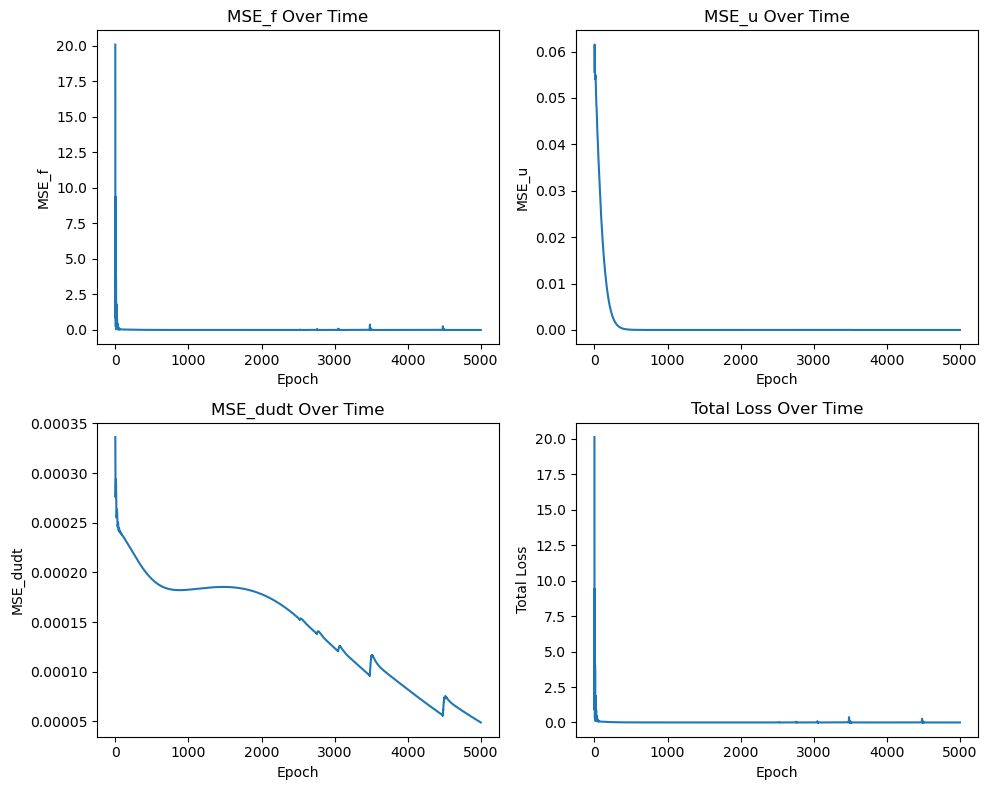

In [9]:

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].plot(range(iterations), mse_f_values)
axs[0, 0].set_title('MSE_f Over Time')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('MSE_f')


axs[0, 1].plot(range(iterations), mse_u_values)
axs[0, 1].set_title('MSE_u Over Time')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('MSE_u')

axs[1, 0].plot(range(iterations), mse_dudt_values)
axs[1, 0].set_title('MSE_dudt Over Time')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('MSE_dudt')


axs[1, 1].plot(range(iterations), total_loss_values)
axs[1, 1].set_title('Total Loss Over Time')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Total Loss')


plt.tight_layout()
plt.show()

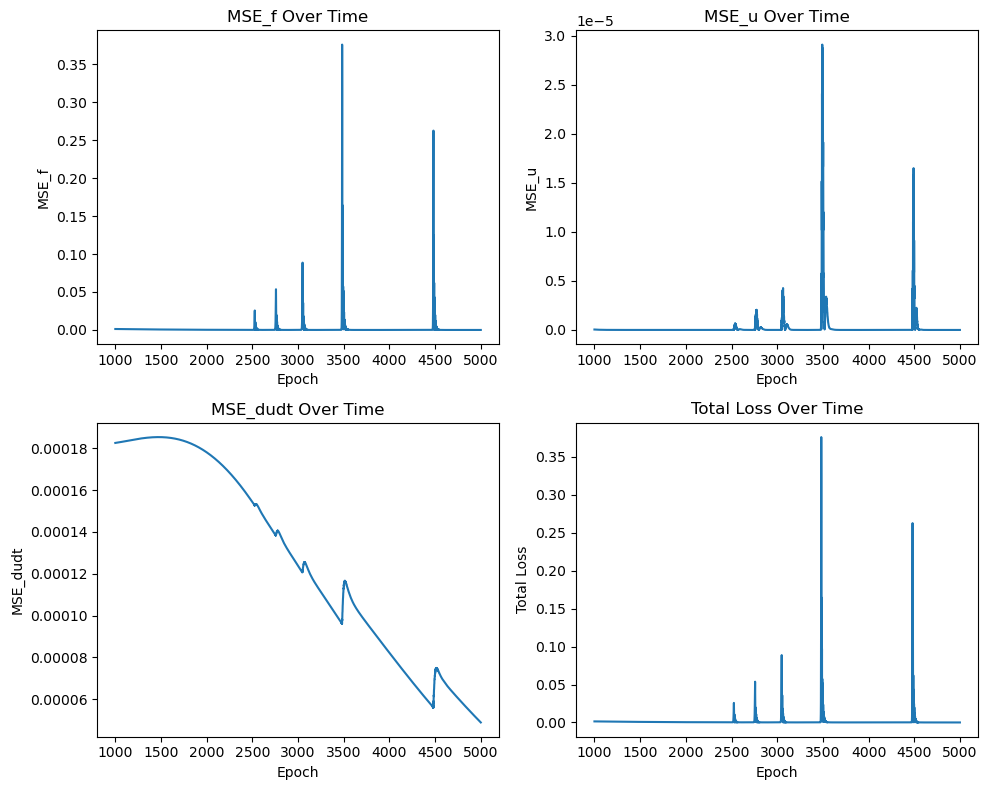

In [10]:


start_iteration = 1000
end_iteration = 5000

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].plot(range(start_iteration, end_iteration), mse_f_values[start_iteration:end_iteration])
axs[0, 0].set_title('MSE_f Over Time')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('MSE_f')

axs[0, 1].plot(range(start_iteration, end_iteration), mse_u_values[start_iteration:end_iteration])
axs[0, 1].set_title('MSE_u Over Time')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('MSE_u')

axs[1, 0].plot(range(start_iteration, end_iteration), mse_dudt_values[start_iteration:end_iteration])
axs[1, 0].set_title('MSE_dudt Over Time')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('MSE_dudt')

axs[1, 1].plot(range(start_iteration, end_iteration), total_loss_values[start_iteration:end_iteration])
axs[1, 1].set_title('Total Loss Over Time')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Total Loss')

plt.tight_layout()
plt.show()


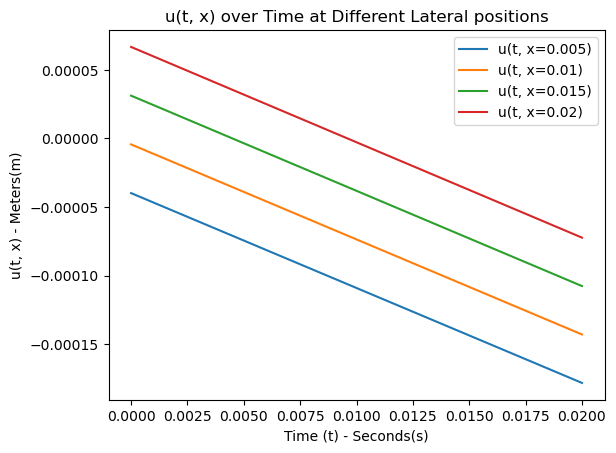

In [11]:

# Define the spatial coordinates for which you want to visualize u(t, x)
selected_x_values = [0.005, 0.010, 0.015, 0.020]
num_test_samples = 1000


# # Set the model to evaluation mode
# net.eval()

# Move the model to the correct device
net.to(device)

# Create a single figure
fig, ax = plt.subplots()

# Plot u(t, x) for each selected x on the same graph
for selected_x in selected_x_values:
    # Predict u(t, x) distribution for the fixed x
    t_flat = np.linspace(0, 0.02, num_test_samples)
    x_flat = np.full_like(t_flat, fill_value=selected_x)
    tx = np.stack([t_flat, x_flat], axis=-1)

    # Convert to torch tensors
    x_tensor = torch.from_numpy(tx[:, 1]).float().view(-1, 1).to(device)
    t_tensor = torch.from_numpy(tx[:, 0]).float().view(-1, 1).to(device)

    # Forward pass
    u = net(x_tensor, t_tensor).detach()

    # Move predicted values to CPU for plotting
    u = u.cpu().numpy()

    # Plot the result
    ax.plot(t_flat, u, label=f'u(t, x={selected_x})')

ax.set_title('u(t, x) over Time at Different Lateral positions')
ax.set_xlabel('Time (t) - Seconds(s)')
ax.set_ylabel('u(t, x) - Meters(m)')
ax.legend()
plt.show()



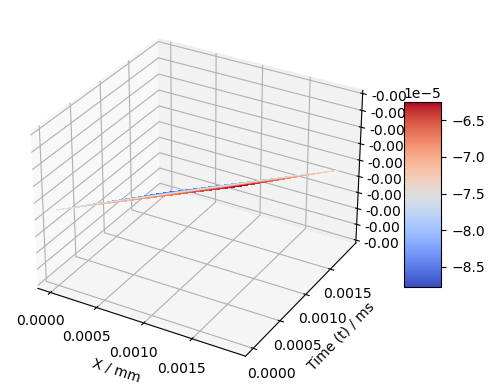

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  # Use add_subplot instead of gca()

# Assuming you have net defined elsewhere
net.eval()
net.to(device)

x = np.arange(0, 0.002, 0.0001)
t = np.arange(0, 0.002, 0.0001)
ms_x, ms_t = np.meshgrid(x, t)
x = np.ravel(ms_x).reshape(-1, 1)
t = np.ravel(ms_t).reshape(-1, 1)

pt_x = torch.from_numpy(x).float().to(device)
pt_t = torch.from_numpy(t).float().to(device)
pt_u = net(pt_x, pt_t)
u = pt_u.detach().cpu().numpy()
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x, ms_t, ms_u, cmap=cm.coolwarm, linewidth=0.1, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set_xlabel('X / mm')
ax.set_ylabel('Time (t) / ms')
ax.set_zlabel('U(t, x) / mm')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


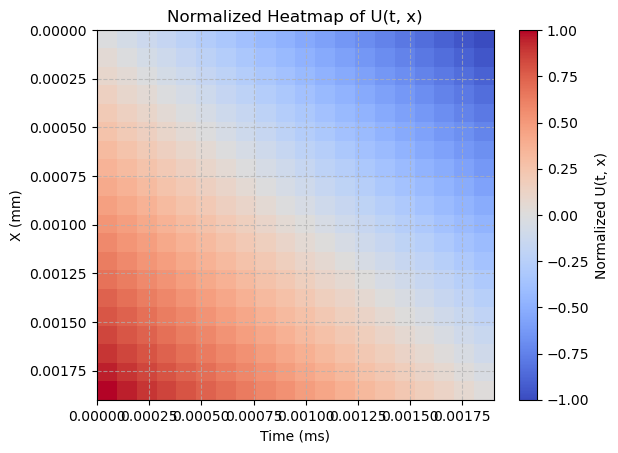

In [13]:
fig, ax = plt.subplots()

# Normalize ms_u to range from -1 to 1
normalized_ms_u = 2 * (ms_u - np.min(ms_u)) / (np.max(ms_u) - np.min(ms_u)) - 1

# Convert normalized_ms_u to a 2D array
ms_u_2d = normalized_ms_u.T

# Create a 2D heatmap
im = ax.imshow(ms_u_2d, extent=[np.min(ms_t), np.max(ms_t), np.min(ms_x), np.max(ms_x)], cmap='coolwarm', aspect='auto', origin='lower', vmin=-1, vmax=1)

# Set labels and title
ax.set_xlabel('Time (ms)')
ax.set_ylabel('X (mm)')
ax.set_title('Normalized Heatmap of U(t, x)')

# Invert y-axis
ax.invert_yaxis()

# Add grid lines for better visualization
ax.grid(True, linestyle='--', alpha=0.7)

# Add a colorbar
cbar = plt.colorbar(im)
cbar.set_label('Normalized U(t, x)')

plt.show()


In [14]:
# Save Model
# torch.save(net.state_dict(), "model_uxt.pt")

In [15]:


# # Define spatial and temporal ranges
# x = np.linspace(0, 20, 1000)  # Unit: millimeters
# t = np.linspace(0, 20, 1000)  # Unit: milliseconds

# # Create Gaussian distribution G(x)
# sigma_g = 0.5  # Adjusted for wider distribution
# gaussian_x = np.exp(-((x)/2)**2 / (2 * sigma_g**2))


# # Define rectangular window function W(t) 
# start_time = 0
# end_time = 0.6
# window_t_shifted = ((t >= start_time) & (t <= end_time)).astype(float)

# product = gaussian_x* window_t_shifted


# # Plot Gaussian distribution G(x)
# plt.plot(x, gaussian_x)
# plt.title('Gaussian Distribution G(x)')
# plt.xlabel('Space (millimeters)')
# plt.ylabel('Amplitude')
# plt.show()

# # Plot shifted rectangular window function W(t)
# plt.plot(t, window_t_shifted)
# plt.title('Shifted Rectangular Window Function W(t)')
# plt.xlabel('Time (milliseconds)')
# plt.ylabel('Amplitude')
# plt.show()


# # Plot the product
# plt.plot(x, product)
# plt.title('Product of Gaussian and Window Function (1D)')
# plt.xlabel('Space (millimeters)')
# plt.ylabel('Amplitude')
# plt.show()